<a href="https://colab.research.google.com/github/RayNG123/stock-price-prediction/blob/main/03_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

from sklearn.neighbors import KNeighborsClassifier

In [2]:
aapl = yf.Ticker('AAPLE')
date_from = str(dt.date.today() - dt.timedelta(days=1000))
date_to = str(dt.date.today())

print(f'Downloading Apple stock data from {date_from} to {date_to}.')
apple = yf.download("AAPL", start=date_from, end=date_to)
apple.reset_index(inplace = True)

[*********************100%***********************]  1 of 1 completed


In [3]:
def backtesting(model,
                days_trained,
                window_trained,
                data,
                target_column):
  #test if days matched
  total_length = apple.shape[0]
  assert days_trained + window_trained < total_length, 'days used for training should be less than all data'
  assert window_trained < days_trained, 'window used for training should be less than days trained'

  #get returns
  data['returns'] = data[target_column].pct_change()
  data['positions'] = 0
  data.dropna(inplace = True)
  data.reset_index(drop = True, inplace = True)

  start_index = 0
  start_trade_index = start_index + days_trained + window_trained + 1
  #Training and Trading
  while start_trade_index < total_length:
    training_set = data.iloc[start_index:start_trade_index]['returns']

    training_data = pd.DataFrame()

    for i in range(1,window_trained+1):
      training_data['x' + str(i)] = training_set.shift(i)

    #Final training data
    training_data['target'] = training_set.apply(lambda x:1 if x >= 0 else 0)
    training_data.dropna(inplace = True)
    training_data.reset_index(inplace = True, drop = True)

    #Train-test split
    X_train = training_data.loc[:,'x1':'x' + str(window_trained)]
    y_train = training_data['target']

    X_train, X_test = X_train.iloc[:-1], X_train.iloc[-1].values.reshape(1,-1)
    y_train, y_test = y_train.iloc[:-1].values, y_train.iloc[-1]

    #Fit model
    model =  KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train,y_train)
    pred = model.predict_proba(X_test)[0][1]
    data['positions'][start_trade_index] = pred

    start_index += 1
    start_trade_index += 1
    print(start_index)

  return data



In [ ]:
a = backtesting('model',
            500,
            20,
            apple,
            'Adj Close')

In [ ]:
a

,Date,Open,High,Low,Close,Adj Close,Volume,returns,positions
0,2020-09-17,109.720001,112.199997,108.709999,110.339996,108.527321,178011000,-0.015964,0.000000
1,2020-09-18,110.400002,110.879997,106.089996,106.839996,105.084824,287104900,-0.031720,0.000000
2,2020-09-21,104.540001,110.190002,103.099998,110.080002,108.271599,195713800,0.030326,0.000000
3,2020-09-22,112.680000,112.860001,109.160004,111.809998,109.973175,183055400,0.015716,0.000000
4,2020-09-23,111.620003,112.110001,106.769997,107.120003,105.360237,150718700,-0.041946,0.000000
...,...,...,...,...,...,...,...,...,...
683,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,-0.002060,0.666667
684,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,-0.007756,0.666667
685,2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900,0.015465,1.000000
686,2023-06-09,181.500000,182.229996,180.630005,180.960007,180.960007,48870700,0.002160,0.333333


In [ ]:
a['buy'] = a['positions'] > 0.34

In [ ]:
a

,Date,Open,High,Low,Close,Adj Close,Volume,returns,positions,buy
0,2020-09-17,109.720001,112.199997,108.709999,110.339996,108.527321,178011000,-0.015964,0.000000,False
1,2020-09-18,110.400002,110.879997,106.089996,106.839996,105.084824,287104900,-0.031720,0.000000,False
2,2020-09-21,104.540001,110.190002,103.099998,110.080002,108.271599,195713800,0.030326,0.000000,False
3,2020-09-22,112.680000,112.860001,109.160004,111.809998,109.973175,183055400,0.015716,0.000000,False
4,2020-09-23,111.620003,112.110001,106.769997,107.120003,105.360237,150718700,-0.041946,0.000000,False
...,...,...,...,...,...,...,...,...,...,...
683,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,-0.002060,0.666667,True
684,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,-0.007756,0.666667,True
685,2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900,0.015465,1.000000,True
686,2023-06-09,181.500000,182.229996,180.630005,180.960007,180.960007,48870700,0.002160,0.333333,False


In [ ]:
a['strategy'] = a['buy']*a['returns']

In [ ]:
a

,Date,Open,High,Low,Close,Adj Close,Volume,returns,positions,buy,strategy
0,2020-09-17,109.720001,112.199997,108.709999,110.339996,108.527321,178011000,-0.015964,0.000000,False,-0.000000
1,2020-09-18,110.400002,110.879997,106.089996,106.839996,105.084824,287104900,-0.031720,0.000000,False,-0.000000
2,2020-09-21,104.540001,110.190002,103.099998,110.080002,108.271599,195713800,0.030326,0.000000,False,0.000000
3,2020-09-22,112.680000,112.860001,109.160004,111.809998,109.973175,183055400,0.015716,0.000000,False,0.000000
4,2020-09-23,111.620003,112.110001,106.769997,107.120003,105.360237,150718700,-0.041946,0.000000,False,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...
683,2023-06-06,179.970001,180.119995,177.429993,179.210007,179.210007,64848400,-0.002060,0.666667,True,-0.002060
684,2023-06-07,178.440002,181.210007,177.320007,177.820007,177.820007,61944600,-0.007756,0.666667,True,-0.007756
685,2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900,0.015465,1.000000,True,0.015465
686,2023-06-09,181.500000,182.229996,180.630005,180.960007,180.960007,48870700,0.002160,0.333333,False,0.000000


In [ ]:
a['abnormal'] = a['strategy'] - a['returns']

<Axes: >

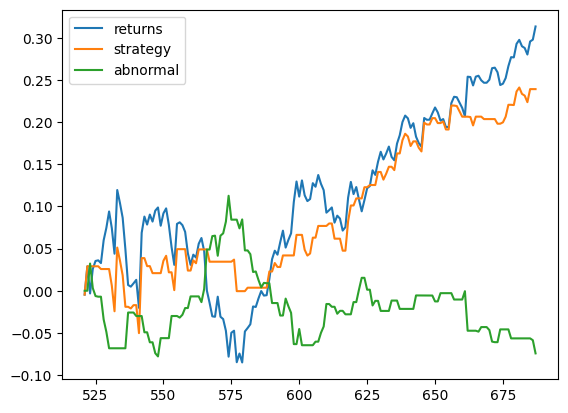

In [ ]:
a.iloc[521:][['returns','strategy','abnormal']].cumsum().plot()